In [158]:
%matplotlib inline

In [159]:
import matplotlib.pyplot as plt
import numpy as np
import time
import math
from collections import Counter

from tiles import *

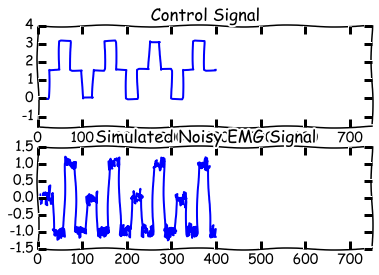

In [160]:
plt.xkcd()  # Yes...

tmax = 400

t = tmax*np.linspace(0, 1, tmax, endpoint=False)

targetElbow = np.zeros(tmax)

steps = tmax / 4
for i in range(0, tmax, steps):
    
    # Define the target angles 
    targetElbow[i:i+(steps/4)] = 0
    targetElbow[i+(steps/4):i+(steps/2)] = math.pi/2
    targetElbow[i+(steps/2):i+(3*steps/4)] = math.pi
    targetElbow[i+(3*steps/4):i+steps] = math.pi/2

# Two subplots, unpack the axes array immediately
plt.figure(figsize=(40,40))
f, (ax1, ax2) = plt.subplots(2, 1, sharey=False)

ax1.plot(t, targetElbow)
ax1.set_ylim([-math.pi/2, 4])
ax1.set_xlim(0,750)
ax1.set_title('Control Signal')

delay = 10

noise = np.random.normal(0,0.1,tmax)
simEMG = [0] * (tmax+delay)

for i in range(1,tmax):
    if targetElbow[i] == math.pi/2:
        simEMG[i + delay] = -1
    elif targetElbow[i] < math.pi/2:
        simEMG[i + delay] = 0
    elif targetElbow[i] > math.pi/2:
        simEMG[i + delay] = 1
        
simEMGdiff = simEMG[0:tmax]+noise

ax2.plot(t, simEMGdiff)
ax2.set_ylim(-1.5, 1.5)
ax2.set_xlim(0,750)
ax2.set_title('Simulated Noisy EMG Signal')

In [161]:
# Implement a learning algorithm to try to fit the signal

# store the variables for plitting after learning
jointAngle = np.zeros(tmax)

# Initialize the state array for the trajectory
# Possible feedback from the simulated arm includes the angle
# (in radians) and angular velocity (in radians per second) of
# each joint, and the Cartesian position of the end effector.

# The continuous state space is composed of joint angles 
# and differential EMG signals
s = np.array([0,0])

# lambdw = 0.3
# lambdv = 0.7

x = 0

# Actual length is the concatenation at different resolutions
# and the baseline feature
m = 26

# Initialize the learning parameters
gamma = 0.99
lambd = 0.3
alphaV = 0.1/m
alphaW = 0.01/m

# Standard deviation should cover the possible action set
maxAngVel = 1023
stdC = maxAngVel

r = 0

delta = np.zeros(tmax)

agentMean = np.zeros(tmax)
agentStd = np.zeros(tmax)

# this defines the resolution of the tiling
numTilings = 25
resolutions = np.array([5])
# resolutions = np.array([5,8,12,20])
numFeatures = len(s)

featVecLength = sum(np.power(resolutions,numFeatures)*numTilings)+1

# Initialize the weight vectors to zero 
# the should be as long as the feature vector x
elV = np.zeros(featVecLength)
elU = np.zeros(featVecLength)
elS = np.zeros(featVecLength)
v = np.zeros(featVecLength)
wU = np.zeros(featVecLength)
wS = np.zeros(featVecLength)

def featurize(s):
    
    # TODO: all components in s were normalized to the range [0, 1]
    # according to their minimum and maximum possible values
    # (((OldValue - OldMin) * (NewMax - NewMin)) / (OldMax - OldMin)) + NewMin
    newAngle = (((s[0] - 0) * (1 - 0)) / (math.pi - 0)) + 0
    newEMG = (((s[1] - (-1.7)) * (1 - 0)) / (1.7 - (-1.7))) + 0

    x = np.zeros(featVecLength)
    
    # Single active baseline unit
    x[0] = 1 
    
    # For each resolution the features are needed 
    for res in np.nditer(resolutions):
        floatArray = np.array([newAngle*res,newEMG*res])
        tilesOut = tiles(numTilings, featVecLength, floatArray)
    
    x[tilesOut] = 1
    
    # tileArray is the active tiles in this featurization
    
    # This featurization should return a single binary feature vector
    # with exactly m features in x(s) active at any time
    
    # Binary feature vector has a length of 4636426 or
    # sum(np.power(np.array([5,8,12,20]),4)*25)+1
    
    return x

def getReward(newAngle,timeStep):
    # Define the reward function of the system
    # A positive reward of rt = 1.0 was
    # delivered when θw and θe were both within 0.1 radians of
    # their target angles. A reward of rt = −0.5 was delivered
    # in all other cases, in essence penalizing the learning system
    # when the arm’s posture differed from the target posture.
    targetAngle = targetElbow[timeStep]
    
    absAngleError = np.abs(newAngle-targetAngle)
    
    if absAngleError < 0.1:
        r = 0.1
    else:
        r = -0.5

    return r

def perform(vel,s,timeStep):
    
    # take the action and observe the new state and the reward 
    # new state is defined by the new joint angle
    # which is defined by the old joint angle and the new angular velocity
    # which is applied for that time step and the
    # emg signal at that time index 
    
    # Calculate the new angular state of the joint
    # old angle + angular velocity * time (in this case time = 5ms, the period of action selection)
    # this limits the amount of motion of the joint possible in each action selection
    
    # newAngle = old angle + (angular velocity * time)
    newAngle = s[0] + (vel * 0.005)
    
    # Angle of the joint is limited
    if newAngle < 0:
        newAngle = 0
    elif newAngle > math.pi:
        newAngle = math.pi
    
    # Define the new state space with the new angle and the emg information
    s = np.array([newAngle,simEMGdiff[timeStep]])
    
    # Get the reward for the new angle
    r = getReward(newAngle,timeStep)
    
    return r,s

# process the training samples that are given
for i in range(tmax):
    
    # Store joint angles for plotting
    jointAngle[i] = s[0]
   
    # Featurize the state
    x = featurize(s)
    
    # Calculate the mean of the action selection
    agentMean[i] = np.dot(wU,x)
    
#     print np.exp(np.dot(wS,x)+np.log(stdC))
    agentStd[i] = max(1,np.exp(np.dot(wS,x) + np.log(stdC)))
    
    # get the action from the normal distribution
    a = round(np.random.normal(agentMean[i],np.power(agentStd[i],2)))
    
    # angular velocity commands are sent to joints (simulated servos) 
    # as integers in the range [−maxAngVel, maxAngVel] in radians/sec
    
    if a < -maxAngVel:
        a = -maxAngVel
    elif a > maxAngVel:
        a = maxAngVel
 
    # take action a and observe the reward, r, and the new state, s
    r,s = perform(a,s,i)              
    newX = featurize(s)

    # Calculate the TD Error based on the old state and the new state
    delta[i] = r + (gamma * np.dot(v,newX)) - np.dot(v,x)
    
    # Critic's eligibility traces 
    elV = lambd * elV + x
    
    # Updated eligibility trace from the 2013 paper
    #    elV = min(1,elV)
    
    # Critic's parameter vector
    v = v + alphaV * delta[i] * elV
    
    elU = lambd * elU + np.multiply((a - agentMean[i]),x)
    wU = wU + alphaW * delta[i] * elU
    
    elS = lambd * elS + np.multiply(((np.power((a - agentMean[i]),2) / np.power(agentStd[i],2)) - 1),x)
    wS = wS + alphaW * delta[i] * elS
    
    print 'Step: ' + str(i)
    print 'Joint Angle: ' + str(jointAngle[i]) + ' radians'
    print 'Target Angle: ' + str(simEMGdiff[i]) + ' radians'
    print 'Agent Mean: ' + str(agentMean[i])
    print 'Agent Std: ' + str(agentStd[i])
    print 'Action: ' + str(a) + ' radians per second'
    print 'New Joint Angle: ' + str(s[0]) + ' radians'
    print 'Reward: ' + str(r)
    print 'TD Error: ' + str(delta[i])
    print '\n'

Step: 0
Joint Angle: 0.0 radians
Target Angle: 0.0107788099868 radians
Agent Mean: 0.0
Agent Std: 1023.0
Action: -1023 radians per second
New Joint Angle: 0.0 radians
Reward: 0.1
TD Error: 0.1


Step: 1
Joint Angle: 0.0 radians
Target Angle: 0.0535563975772 radians
Agent Mean: -1.023
Agent Std: 1023.0
Action: 1023 radians per second
New Joint Angle: 3.14159265359 radians
Reward: -0.5
TD Error: -0.509238461538


Step: 2
Joint Angle: 3.14159265359 radians
Target Angle: -0.00563238209412 radians
Agent Mean: -0.359605087118
Agent Std: 1022.99919814
Action: 1023 radians per second
New Joint Angle: 3.14159265359 radians
Reward: -0.5
TD Error: -0.499956768462


Step: 3
Joint Angle: 3.14159265359 radians
Target Angle: -0.0568862346078 radians
Agent Mean: -4.96834978122
Agent Std: 1022.99577347
Action: 1023 radians per second
New Joint Angle: 3.14159265359 radians
Reward: -0.5
TD Error: -0.495692137227


Step: 4
Joint Angle: 3.14159265359 radians
Target Angle: 0.0167050472776 radians
Agent Mean

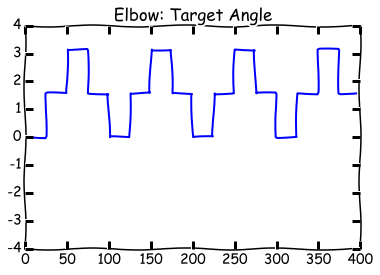

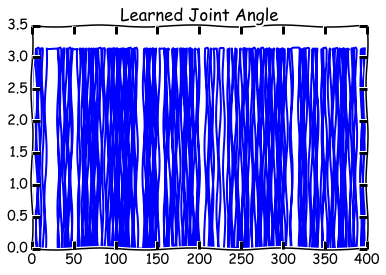

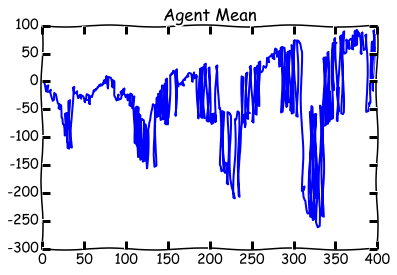

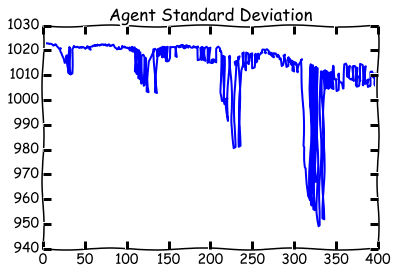

In [162]:
# Visualize the learning    
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(t, targetElbow)
ax1.set_ylim(-4,4)
ax1.set_title('Elbow: Target Angle')

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(t, jointAngle)
ax1.set_title('Learned Joint Angle')

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(t, agentMean)
ax1.set_title('Agent Mean')

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(t, agentStd)
ax1.set_title('Agent Standard Deviation')

##### 